In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# exam tables we have
csv_files = os.listdir("../input")
print(">>>> WE HAVE THESE TABLES: <<<<")
print()
for csv_file in csv_files:
    if (csv_file != "HomeCredit_columns_description.csv" and csv_file != "application_test.csv"):
        print(csv_file.split(".")[0])

>>>> WE HAVE THESE TABLES: <<<<

previous_application
bureau_balance
installments_payments
application_train
sample_submission
POS_CASH_balance
credit_card_balance
bureau


In [3]:
# exam the application_train table
application_train = pd.read_csv('../input/application_train.csv')
print('Size of application_train data', application_train.shape)

Size of application_train data (307511, 122)


In [13]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# checking missing data
total = application_train.isnull().sum().sort_values(ascending = False)
percent = (application_train.isnull().sum()/application_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_application_train_data.head(5))
print("\nsince there are no features that has a missing rate larger than 75%, we will keep all of them")

                           Total    Percent
COMMONAREA_MEDI           214865  69.872297
COMMONAREA_AVG            214865  69.872297
COMMONAREA_MODE           214865  69.872297
NONLIVINGAPARTMENTS_MODE  213514  69.432963
NONLIVINGAPARTMENTS_MEDI  213514  69.432963

since there are no features that has a missing rate larger than 75%, we will keep all of them


In [5]:
#1 Factorize binary categorical features
binary_categorical_features = ['CODE_GENDER', "FLAG_OWN_CAR", 'FLAG_OWN_REALTY']
for bin_feature in binary_categorical_features:
    application_train[bin_feature], uniques = pd.factorize(application_train[bin_feature])
    
# One-hot encoding for categorical columns with get_dummies

# Note we can handle the missing values of categorical features in this way:
# Add a new dummy feature (is_nan) to indicate it's missing
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

application_train, cat_cols = one_hot_encoder(application_train, True)
print(len(cat_cols))
print('Size of application_train data', application_train.shape)

146
Size of application_train data (307511, 255)


The non-anomalies default on 8.07% of loans
The anomalies default on nan% of loans
There are 0 anomalous days of employment
Size of application_train data (307511, 256)


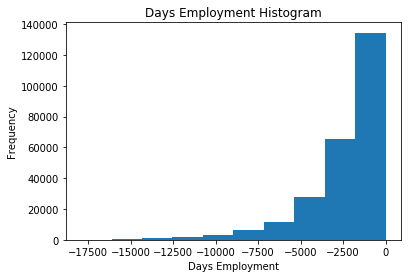

In [12]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
        print('Size of application_train data', application_train.shape)

In [16]:
# Base Line: Logistic Regression Model
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in application_train:
    train = application_train.drop(columns = ['TARGET'])
else:
    train = application_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)

print('Training data shape: ', train.shape)

/home/wenxuan/anaconda3/envs/home-credit/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 255)


In [19]:
train_labels = application_train['TARGET']
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

/home/wenxuan/anaconda3/envs/home-credit/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [20]:
log_reg.score(train, train_labels)

0.9192711805431351